In [1]:
import numpy as np
from scipy import fftpack as fp
import matplotlib.pyplot as plt
from skimage import color, io
from skimage.transform import rescale

In [2]:
def dftuv(M, N):
	""" DFTUV Computes meshgrid frequency matrices.
	[U, V] = DFTUV(M, N) computes meshgrid frequency matrices U and
	V. U and V are useful for computing frequency-domain filter 
	functions that can be used with DFTFILT. U and V are both M-by-N. """

	# Set up range of variables.
	u = np.arange(M)
	v = np.arange(N)

	# Compute the indices for use in meshgrid
	for i in range(M//2+1, M):
		u[i] = u[i] - M
	for i in range(N//2+1, N):
		v[i] = v[i] - N

	# Return the meshgrid arrays
	return np.meshgrid(v,u)

In [3]:
def lpfilter(tipe, M, N, D0, n = 1): 
	""" LPFILTER Computes frequency domain lowpass filters
    H = LPFILTER(TYPE, M, N, D0, n) creates the transfer function of
    a lowpass filter, H, of the specified TYPE and size (M-by-N).  To
    view the filter as an image or mesh plot, it should be centered
    using H = fftshift(H).
 
    Valid values for TYPE, D0, and n are:
 
    'ideal'    Ideal lowpass filter with cutoff frequency D0.  n need
               not be supplied.  D0 must be positive
 
    'btw'      Butterworth lowpass filter of order n, and cutoff D0.
               The default value for n is 1.0.  D0 must be positive.

    'gaussian' Gaussian lowpass filter with cutoff (standard deviation)
 	           D0.  n need not be supplied.  D0 must be positive. """

 	# Use function dftuv to set up the meshgrid arrays needed for 
 	# computing the required distances.
	U, V = dftuv(M, N)

	# Compute the distances D(U, V).
	D = np.sqrt(U**2+V**2)

	# Begin fiter computations.
	if (tipe == 'gaussian'):
		return np.exp(-(D**2)/(2*(D0**2)))
	elif (tipe == 'btw'):
		return 1/(1 + (D/D0)**(2*n))
	elif (tipe == 'ideal'):
		return (D <= D0)
	else:
		print("Invalid type.")

In [4]:
def hpfilter(tipe, M, N, D0, n = 1):
	""" HPFILTER Computes frequency domain highpass filters
    H = HPFILTER(TYPE, M, N, D0, n) creates the transfer function of
    a highpass filter, H, of the specified TYPE and size (M-by-N).
    Valid values for TYPE, D0, and n are:
 
    'ideal'     Ideal highpass filter with cutoff frequency D0.  n
                need not be supplied.  D0 must be positive
 
    'btw'       Butterworth highpass filter of order n, and cutoff D0.
                The default value for n is 1.0.  D0 must be positive.
 
    'gaussian'  Gaussian highpass filter with cutoff (standard deviation)
                D0.  n need not be supplied.  D0 must be positive. """
 

	# The transfer function Hhp of a highpass filter is 1 - Hlp,
	# where Hlp is the transfer function of the corresponding lowpass
	# filter.  Thus, we can use function lpfilter to generate highpass
	# filters.
	
	# Generate highpass filter.
	Hlp = lpfilter(tipe, M, N, D0, n)
	return 1 - Hlp

In [5]:
def notch(tipe, M, N, D0, x, y, n = 1):
	""" notch Computes frequency domain notch filters
    H = NOTCH(TYPE, M, N, D0, x, y, n) creates the transfer function of
    a notch filter, H, of the specified TYPE and size (M-by-N). centered at
    Column X, Row Y in an unshifted Fourier spectrum.
    Valid values for TYPE, D0, and n are:
 
    'ideal'     Ideal highpass filter with cutoff frequency D0.  n
                need not be supplied.  D0 must be positive
 
    'btw'       Butterworth highpass filter of order n, and cutoff D0.
                The default value for n is 1.0.  D0 must be positive.
 
    'gaussian'  Gaussian highpass filter with cutoff (standard deviation)
                D0.  n need not be supplied.  D0 must be positive. """

	# The transfer function Hhp of a highpass filter is 1 - Hlp,
	# where Hlp is the transfer function of the corresponding lowpass
	# filter.  Thus, we can use function lpfilter to generate highpass
	# filters.

	# Generate highpass filter.
	Hlp = lpfilter(tipe, M, N, D0, n)
	H = 1 - Hlp
	H = np.roll(H, y-1, axis=0)
	H = np.roll(H, x-1, axis=1)
	return H

In [6]:
def paddedsize(w, l):
	""" PADDEDSIZE Computes padded sizes useful for FFT-based filtering.
    PQ = PADDEDSIZE(AB), where AB is a two-element size vector,
    computes the two-element size vector PQ = 2*AB. """

	return (2*w, 2*l)

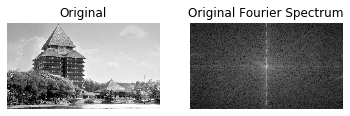

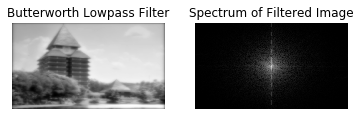

In [7]:
i1 = color.rgb2gray(io.imread('rektorat_ui.jpeg'))
w, l = paddedsize(i1.shape[0], i1.shape[1])
# membuat gaussian lowpass filter
# fungsi lpfilter terdapat di file helper.py
h = lpfilter('btw', w, l, 0.05 * w)
# menghitung DFT citra
f = fp.fft2(i1,(w,l))
# Apply lowpass filter
LPFS_lena = h*f
# convert ke domain spasial
LPF_lena = fp.ifft2(LPFS_lena).real
LPF_lena = LPF_lena[:i1.shape[0],:i1.shape[1]]

# Menampilkan fourier spectrum
Fc = fp.fftshift(f)
Fcf = fp.fftshift(LPFS_lena)
# fungsi abs untuk menghitung magnitude
S1 = np.log(1+abs(Fc))
S2 = np.log(1+abs(Fcf))
plt.subplot(1,2,1); plt.imshow(i1, cmap='gray')
plt.title("Original"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(S1, cmap='gray')
plt.title("Original Fourier Spectrum"); plt.axis("off")
plt.show()

plt.subplot(1,2,1); plt.imshow(LPF_lena, cmap='gray')
plt.title("Butterworth Lowpass Filter"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(S2, cmap='gray')
plt.title("Spectrum of Filtered Image"); plt.axis("off")
plt.show()

#Semakin tinggi nilai D0 semakin turun tingkat smoothnya

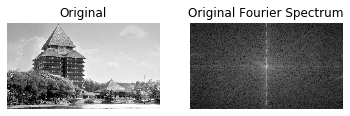

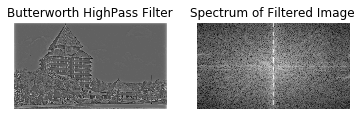

In [8]:
i1 = color.rgb2gray(io.imread('rektorat_ui.jpeg'))
w, l = paddedsize(i1.shape[0], i1.shape[1])
# membuat gaussian lowpass filter
# fungsi lpfilter terdapat di file helper.py
h = hpfilter('btw', w, l, 0.05 * w)
# menghitung DFT citra
f = fp.fft2(i1,(w,l))
# Apply lowpass filter
LPFS_lena = h*f
# convert ke domain spasial
LPF_lena = fp.ifft2(LPFS_lena).real
LPF_lena = LPF_lena[:i1.shape[0],:i1.shape[1]]

# Menampilkan fourier spectrum
Fc = fp.fftshift(f)
Fcf = fp.fftshift(LPFS_lena)
# fungsi abs untuk menghitung magnitude
S1 = np.log(1+abs(Fc))
S2 = np.log(1+abs(Fcf))
plt.subplot(1,2,1); plt.imshow(i1, cmap='gray')
plt.title("Original"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(S1, cmap='gray')
plt.title("Original Fourier Spectrum"); plt.axis("off")
plt.show()

plt.subplot(1,2,1); plt.imshow(LPF_lena, cmap='gray')
plt.title("Butterworth HighPass Filter"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(S2, cmap='gray')
plt.title("Spectrum of Filtered Image"); plt.axis("off")
plt.show()

#Semakin tinggi nilai D0 semakin tajam gambarnya

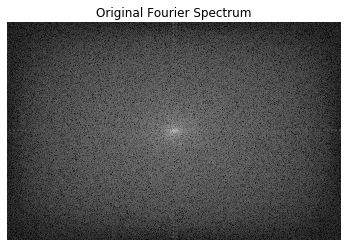

In [31]:
from skimage import io, color, util

bunga = io.imread('flowers_noisy.jpg')
i1 = color.rgb2gray(bunga)

w, l = paddedsize(i1.shape[0], i1.shape[1])
f = fp.fft2(i1, (w,l))
Fc = fp.fftshift(f)
S1 = np.log(1+abs(Fc))
plt.subplot();
plt.imshow(S1, cmap='gray')
plt.title("Original Fourier Spectrum");
plt.axis("off")
plt.show()